# A Little Thesis on the Distribution of Height and Weight of 18-year-olds

## 简介

略

## 数据集

https://tianchi.aliyun.com/dataset/112606

Description:

这是一个简单的数据集。它仅包含25,000个18岁的不同人的身高（英寸）和体重（磅）。该数据集可用于构建可以预测人类身高或体重的模型。

## 准备进行的工作

- 数据处理
    - 转换为公制单位
    - 计算bmi
    - 进一步抽取样本
        - 身高高于173cm：5000人
        - 身高不高于173cm：5000人
- 数据初步分析
    - 计算所有身高和体重的样本均值和样本方差。
    - 绘制身高和体重的直方图。
    - 将身高高于、不高于173cm的人进一步分为两组，分别计算其体重的样本均值和样本方差。
- 点估计（矩）
    - 将身高的分布看作正态分布，计算其均值和方差的矩估计量。
    - 将身高高于173cm体重的分布看作正态分布，计算其均值和方差的矩估计量。
    - 点估计的评价（对于全体身高的上述估计）
        - 无偏性
        - 有效性
        - 一致性
        - 修正
- 区间估计（枢轴量）
    - 将身高的分布看作正态分布，计算其均值和方差的置信区间。
    - 将身高高于173cm体重的分布看作正态分布，计算其均值和方差的置信区间。
- 假设检验
    - 问题：身高高于173cm的人的体重期望是否高于全体的体重均值？（单侧检验）
    - 问题：身高高于173cm的人的bmi是否和不高于173cm的人的bmi分布的均值显著不同？



In [92]:
save_flag = True

In [125]:
# utils
import random
from colorsys import hsv_to_rgb
import colorsys
import matplotlib.pyplot as plt


# a generator that generates a color randomly
def random_color(saturability=0.6, brightness=0.6):
    h = random.random()
    s = saturability
    v = brightness
    return colorsys.hsv_to_rgb(h, s, v)


def normal_distribution(x, mean, variation):
    # calculate the probability density of a normal distribution
    # x: the x of the normal distribution
    # mean: the mean of the normal distribution
    # variation: the variation of the normal distribution
    return 1 / np.sqrt(2 * np.pi * variation) * np.exp(-np.square(x - mean) / (2 * variation))


def plot_histogram(data,
                   title,
                   label,
                   xlabel=None,
                   ylabel=None,
                   bins=100,
                   color='blue',
                   figsize=(10, 6),
                   alpha=1.0,
                   density=True,
                   filename=None,
                   show=True,
                   save=False,
                   plot_normal_distribution=False,
                   mark_mean=True,
                   mark_alpha: list[float] = None,

                   **kwargs):
    # plot a histogram of data
    # make sure all elements on the plot have a legend.

    plt.figure(figsize=figsize)
    plt.hist(data, bins=bins, color=color, alpha=alpha, label=label, density=density)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    mean = data.mean()

    if plot_normal_distribution:
        # plot the normal distribution with the same mean and variation as the data
        variation = data.var()
        x = np.linspace(np.min(data), np.max(data), 1000)
        y = normal_distribution(x, mean, variation)
        plt.plot(x, y, color='r',
                 label='normal distribution',
                 linewidth=3,
                 linestyle='dashed',
                 alpha=0.5)

    if mark_mean:
        # plot the mean as a vertical red line
        plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='mean')
        # create a label attached to the line and tells the value of the mean
        plt.text(mean, plt.ylim()[1] * 0.9, f'mean={data.mean():.3f}', color='r', alpha=0.8)

    if mark_alpha is not None:
        # locate the x where P(X > x) = alpha and plot it as a vertical line. color is randomly chosen.
        for alpha in mark_alpha:
            x = np.quantile(data, 1 - alpha)
            plt.axvline(x, color=random_color(brightness=0.75), linestyle='dashed', linewidth=1,
                        label=f'alpha={alpha:.3f}')

    plt.legend()
    plt.tight_layout()

    if save:
        plt.savefig(filename)
    if show:
        plt.show()
    plt.close()


## 正文

数据处理略。

In [94]:
import pandas as pd
import numpy as np
import sympy as sp

In [95]:
# 读取数据
data_all_dir = '../data/DataAll.csv'
data_taller_dir = '../data/DataTaller.csv'
data_shorter_dir = '../data/DataShorter.csv'

data_all_csv = pd.read_csv(data_all_dir)
data_taller_csv = pd.read_csv(data_taller_dir)
data_shorter_csv = pd.read_csv(data_shorter_dir)

height_all = data_all_csv['Height(cm)'].to_numpy(dtype=np.float32)
weight_all = data_all_csv['Weight(kg)'].to_numpy(dtype=np.float32)
weight_taller = data_taller_csv['Weight(kg)'].to_numpy(dtype=np.float32)
weight_shorter = data_shorter_csv['Weight(kg)'].to_numpy(dtype=np.float32)

bmi_taller = data_taller_csv['BMI'].to_numpy(dtype=np.float32)
bmi_shorter = data_shorter_csv['BMI'].to_numpy(dtype=np.float32)

sample_size = len(height_all)
sample_taller_size = len(weight_taller)
sample_shorter_size = len(weight_shorter)

### 数据初步分析

计算所有身高和体重的样本均值和样本方差。

利用公式：

$$ \bar{X} = \frac{1}{n} \sum_{i=1}^{n} X_i $$

$$ S^2 = \frac{1}{n-1} \sum_{i=1}^{n} (X_i - \bar{X})^2 = \frac{1}{n-1} \sum_{i=1}^{n} X_i^2 - \frac{n}{n-1} \bar{X}^2 $$

In [96]:
def mean_and_variation(data):
    # calculate the mean and variation of data
    # data: a numpy array
    # return: mean, variation
    mean = np.mean(data)
    variation = np.sum(np.square(data - mean)) / (data.shape[0] - 1)
    return mean, variation

In [97]:


avg_height_all, var_height_all = mean_and_variation(height_all)
avg_weight_all, var_weight_all = mean_and_variation(weight_all)
avg_weight_taller, var_weight_taller = mean_and_variation(weight_taller)
avg_weight_shorter, var_weight_shorter = mean_and_variation(weight_shorter)

print(f'全体身高均值：{avg_height_all:.2f}')
print(f'全体体重均值：{avg_weight_all:.2f}')
print(f'全体身高方差：{var_height_all:.4f}')
print(f'全体体重方差：{var_weight_all:.4f}')
print(f'身高高于173cm的体重均值：{avg_weight_taller:.2f}')
print(f'身高高于173cm的体重方差：{var_weight_taller:.4f}')
print(f'身高不高于173cm的体重均值：{avg_weight_shorter:.2f}')
print(f'身高不高于173cm的体重方差：{var_weight_shorter:.4f}')



全体身高均值：172.70
全体体重均值：57.64
全体身高方差：23.3315
全体体重方差：27.9766
身高高于173cm的体重均值：59.99
身高高于173cm的体重方差：22.8804
身高不高于173cm的体重均值：55.59
身高不高于173cm的体重方差：23.6030


代入数据。用$X$表示身高，$Y$表示体重；$Y_a$ 表示身高高于173cm的体重，$Y_b$ 表示身高不高于173cm的体重。

$\bar{X} = 172.70$

$S^2 = 23.3315$

$\bar{Y} = 57.64$

$S^2 = 27.9766$

$\bar{Y_a} = 59.83$

$S^2 = 23.5395$

$\bar{Y_b} = 55.61$

$S^2 = 23.2043$


全体身高均值：172.70
全体体重均值：57.64
全体身高方差：23.3315
全体体重方差：27.9766
身高高于173cm的体重均值：59.83
身高高于173cm的体重方差：23.5395
身高不高于173cm的体重均值：55.61
身高不高于173cm的体重方差：23.2043

绘制身高和体重的直方图。

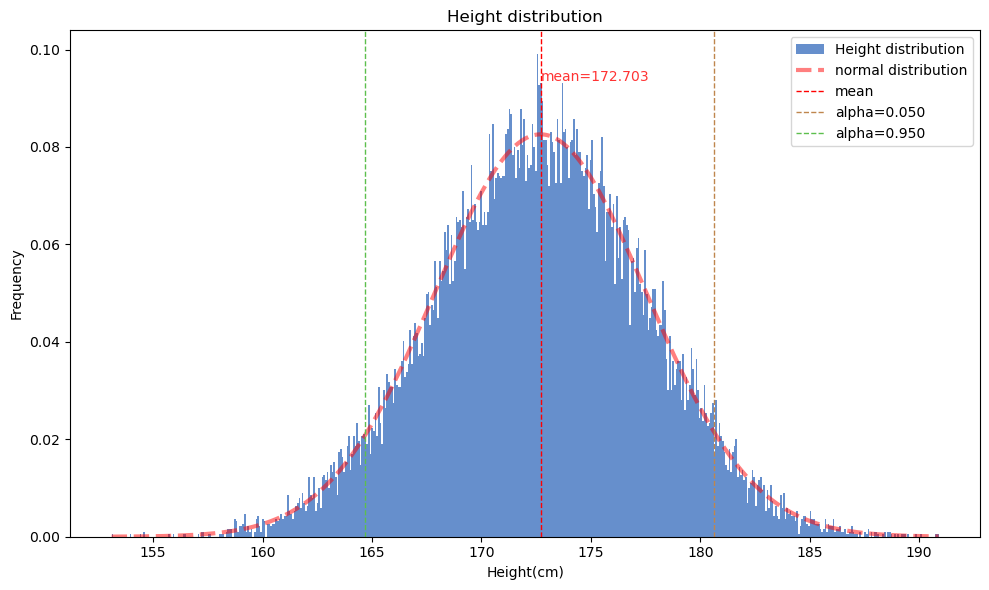

In [127]:
plot_histogram(height_all,
               title="Height distribution",
               label="Height distribution",
               color=hsv_to_rgb(0.6, 0.5, 0.8),
               xlabel="Height(cm)",
               ylabel="Frequency",
               bins=500,
               mark_alpha=[0.05, 0.95],
               plot_normal_distribution=True,
               density=True,
               filename="../image/全体身高.svg",
               save=save_flag)

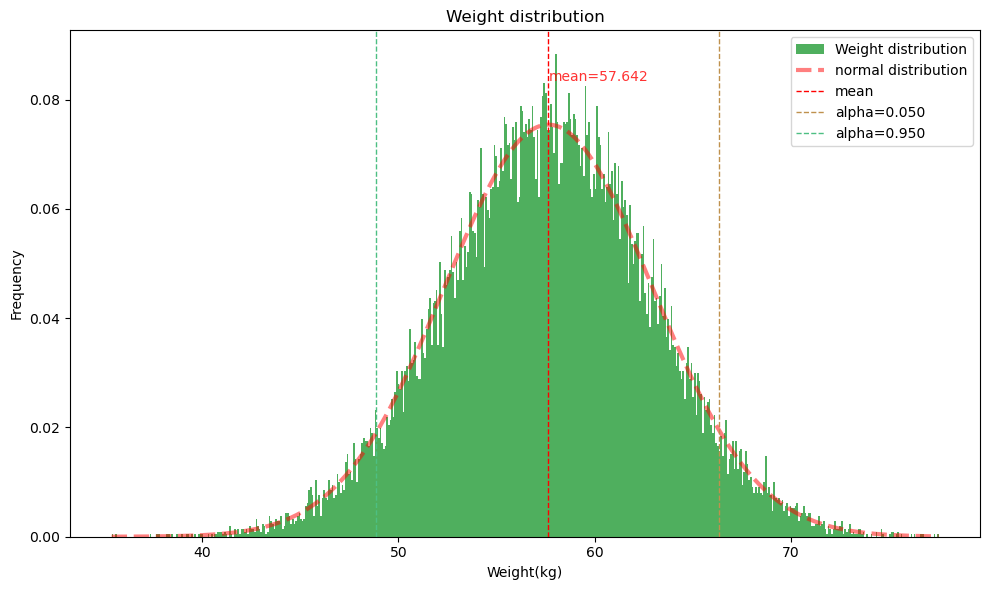

In [128]:
plot_histogram(weight_all,
               title="Weight distribution",
               label="Weight distribution",
               xlabel="Weight(kg)",
               ylabel="Frequency",
               color='#4faf5e',
               bins=500,
               mark_alpha=[0.05, 0.95],
               plot_normal_distribution=True,
               density=True,
               filename="../image/全体体重.svg",
               save=save_flag)

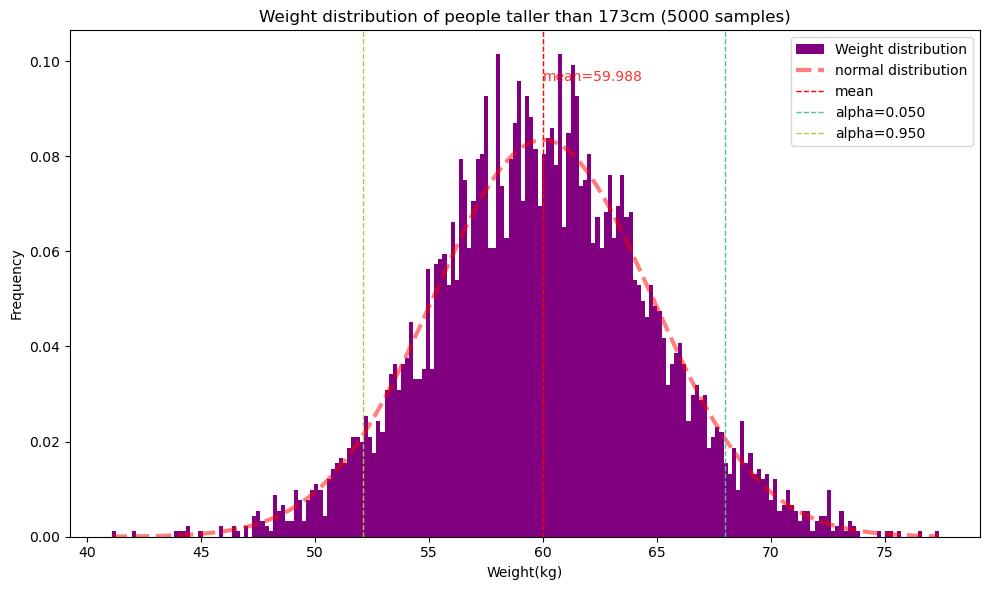

In [129]:
plot_histogram(weight_taller,
               title=f"Weight distribution of people taller than 173cm ({sample_taller_size} samples)",
               label="Weight distribution",
               xlabel="Weight(kg)",
               ylabel="Frequency",
               color='purple',
               bins=200,
               mark_alpha=[0.05, 0.95],
               plot_normal_distribution=True,
               density=True,
               filename="../image/高个子体重.svg",
               save=save_flag)


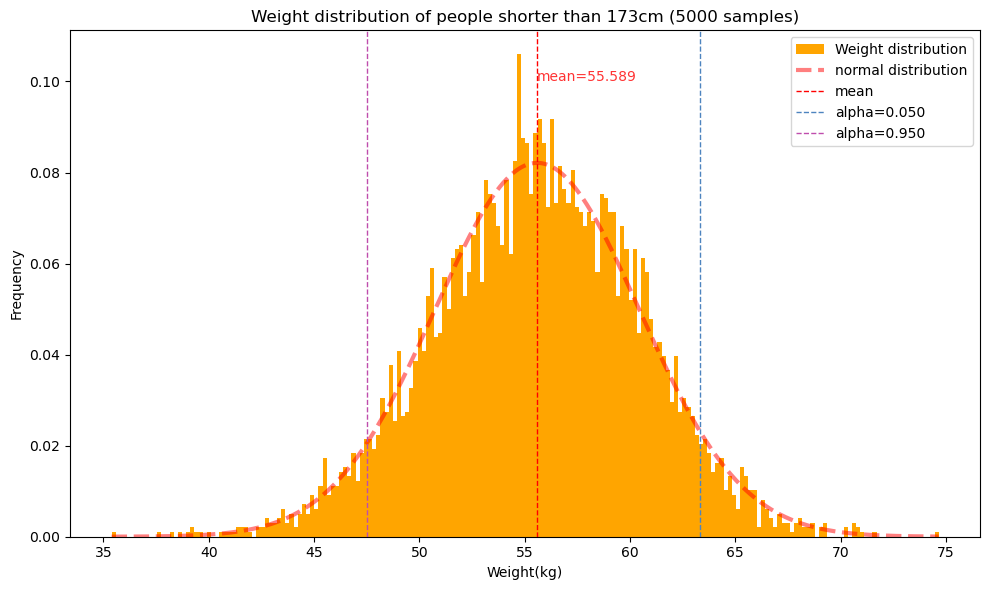

In [130]:
plot_histogram(weight_shorter,
               title=f"Weight distribution of people shorter than 173cm ({sample_shorter_size} samples)",
               label="Weight distribution",
               xlabel="Weight(kg)",
               ylabel="Frequency",
               color='orange',
               bins=200,
               mark_alpha=[0.05, 0.95],
               plot_normal_distribution=True,
               density=True,
               filename="../image/矮个子体重.svg",
               save=save_flag)

### 点估计

通常意义上点估计的目的：我们常常会遇到总体$X$的分布函数$F(x;\theta_1,\theta_2,\cdots,\theta_k)$
的形式已知，但其中的参数$\theta_1,\theta_2,\cdots,\theta_k$未知的情况。
可以利用样本$X_1,X_2,\cdots,X_n$对参数$\theta_1,\theta_2,\cdots,\theta_k$进行估计。
做法是：对总体$X$取出一个样本$X_1,X_2,\cdots,X_n$，
根据一定的原理构造统计量$\hat{\theta_j} = \hat{\theta_j}(X_1,X_2,\cdots,X_n)$，
然后再代入样本数据$(x_1, x_2, \cdots, x_n)$，由此对未知参数$\theta_j$进行估计。

常用的点估计方法有频率替代法、矩估计法、最大似然估计法等。

下面我们将用矩估计法对身高和体重的均值和方差进行估计。

#### 矩估计法

矩估计法的基本思想是：用样本矩去估计相应的总体矩。

假设总体的k阶原点矩存在，记$ E(X^k) = \mu_k(\theta_1,\theta_2,\cdots,\theta_k) $是关于$\theta_1,\theta_2,\cdots,\theta_k$的函数。

根据大数定律，用样本矩$\hat{\mu_k} = \frac{1}{n} \sum_{i=1}^{n} X_i^k$去估计总体矩$\mu_k$，列出方程组：

$$ \left\{
\begin{aligned}
\mu_1(\theta_1,\theta_2,\cdots,\theta_k) &= \frac{1}{n} \sum_{i=1}^{n} X_i \\
\mu_2(\theta_1,\theta_2,\cdots,\theta_k) &= \frac{1}{n} \sum_{i=1}^{n} X_i^2 \\
\cdots \\
\mu_k(\theta_1,\theta_2,\cdots,\theta_k) &= \frac{1}{n} \sum_{i=1}^{n} X_i^k \\
\end{aligned}
\right.
$$

解出$\theta_1,\theta_2,\cdots,\theta_k$，即得到$\theta_1,\theta_2,\cdots,\theta_k$的矩估计量。

代入样本值得到矩估计量的样本值

$ \hat{\theta_j} = \hat{\theta_j}(x_1,x_2,\cdots,x_n) $


#### 用矩估计法估计身高的均值和方差

设身高的分布为正态分布，记其均值为$\mu$，方差为$\sigma^2$。

由中心矩$E(X) = \mu$，$E(X^2) = \mu^2 + \sigma^2$，

列出方程组：

$$ \left\{ \begin{aligned}
\mu &= \frac{1}{n} \sum_{i=1}^{n} X_i \\
\mu^2 + \sigma^2 &= \frac{1}{n} \sum_{i=1}^{n} X_i^2 \\
\end{aligned} \right. $$

In [102]:
# use sympy to solve the equation
mu, sigma = sp.symbols('mu sigma')
eq1 = sp.Eq(mu, 1 / sample_size * np.sum(height_all))
eq2 = sp.Eq(mu ** 2 + sigma ** 2, 1 / sample_size * np.sum(np.square(height_all)))
res_all = sp.solve([eq1, eq2], [mu, sigma ** 2], dict=True)[0]

print(f'身高的均值的矩估计量：{res_all[mu]:.4f}')
print(f'身高的方差的矩估计量：{res_all[sigma ** 2]:.6f}')

身高的均值的矩估计量：172.7025
身高的方差的矩估计量：23.326946


解得矩估计量

$ \hat{\mu} = 172.7025 $

$ \hat{\sigma^2} = 23.326946 $

#### 用矩估计法估计身高高于173cm的体重的均值和方差

设身高高于173cm的体重的分布为正态分布，记其均值为$\mu_a$，方差为$\sigma_a^2$。

由中心矩$E(X) = \mu_a$，$E(X^2) = \mu_a^2 + \sigma_a^2$，

列出方程组：

$$ \left\{ \begin{aligned}
\mu_a &= \frac{1}{n} \sum_{i=1}^{n} X_i \\
\mu_a^2 + \sigma_a^2 &= \frac{1}{n} \sum_{i=1}^{n} X_i^2 \\
\end{aligned} \right. $$

In [103]:
# use sympy to solve the equation
mu_a, sigma_a = sp.symbols('mu_a sigma_a')
eq1 = sp.Eq(mu_a, 1 / sample_taller_size * np.sum(weight_taller))
eq2 = sp.Eq(mu_a ** 2 + sigma_a ** 2, 1 / sample_taller_size * np.sum(np.square(weight_taller)))
res_taller = sp.solve([eq1, eq2], [mu_a, sigma_a ** 2], dict=True)[0]

print(f'身高高于173cm的体重的均值的矩估计量：{res_taller[mu_a]:.4f}')
print(f'身高高于173cm的体重的方差的矩估计量：{res_taller[sigma_a ** 2]:.6f}')

身高高于173cm的体重的均值的矩估计量：59.9878
身高高于173cm的体重的方差的矩估计量：22.875851


解得矩估计量

$ \hat{\mu_a} = 59.9878 $

$ \hat{\sigma_a^2} = 22.875851 $

### 点估计的评价标准

点估计的常用评价标准有：无偏性、有效性、一致性。

#### 无偏性

设$\hat{\theta}$是$\theta$的估计量，如果

$$ E(\hat{\theta}) = \theta $$

则称$\hat{\theta}$是$\theta$的无偏估计量。

#### 有效性

设$\hat{\theta_1}$和$\hat{\theta_2}$都是$\theta$的无偏估计量，如果

$$ D(\hat{\theta_1}) \leq D(\hat{\theta_2}) $$

则称$\hat{\theta_1}$比$\hat{\theta_2}$有效。

Rao-Cramer不等式：设$\hat{\theta}$是$\theta$的无偏估计量，如果$\hat{\theta}$的方差存在，则

$$ D(\hat{\theta}) \geq I(\theta) = \frac{1}{n E (\frac{\partial}{\partial \theta} \ln f(X;\theta))^2} $$

I(\theta)称为无偏估计的方差下界。

有效估计量：设$\hat{\theta}_0$ 是$\theta$的无偏估计量，如果在所有无偏估计量中，$\hat{\theta}_0$的方差最小，则称$\hat{\theta}_0$是$\theta$的有效估计量。

P193. Rao-Cramer不等式暗示：只要某个无偏估计量的方差达到了无偏估计的方差下界，那么这个无偏估计量就是有效估计量。

#### 一致性

设$\hat{\theta}$是$\theta$的估计量，如果

$$ \lim_{n \to \infty} P(|\hat{\theta} - \theta| < \epsilon) = 1 $$

即随机变量序列$\hat{\theta_1},\hat{\theta_2},\cdots,\hat{\theta_n}$依概率收敛于$\theta$，则称$\hat{\theta}$是$\theta$的一致估计量。

#### 对身高的矩估计量的评价

无偏性检验：
 
$\mu$的矩估计量为 $\hat{\mu} = \frac{1}{n} \sum_{i=1}^{n} X_i = \bar{X}$，
其数学期望为 $E(\hat{\mu}) = E( \frac{1}{n} \sum_{i=1}^{n} X_i ) = \frac{1}{n} \sum_{i=1}^{n} E(X_i) = \frac{1}{n} \sum_{i=1}^{n} \mu = \mu$，
所以矩估计量$\hat{\mu}$是$\mu$的无偏估计量。

$\sigma^2$的矩估计量为 $\hat{\sigma^2} = \frac{1}{n} \sum_{i=1}^{n} X_i^2 - \bar{X}^2$，
其数学期望为 

$$E(\hat{\sigma^2}) = E( \frac{1}{n} \sum_{i=1}^{n} X_i^2 - \bar{X}^2 ) = \frac{1}{n} \sum_{i=1}^{n} E(X_i^2) - E(\bar{X}^2) = \frac{1}{n} \sum_{i=1}^{n} (\mu^2 + \sigma^2) - (\mu^2 + \frac{\sigma^2}{n}) = \frac{n-1}{n} \sigma^2$$

不等于$\sigma^2$，所以矩估计量$\hat{\sigma^2}$不是$\sigma^2$的无偏估计量。

可以将矩估计量$\hat{\sigma^2}$修正为

$$\hat{\sigma_{修正}^2} = \frac{n}{n-1} (\frac{1}{n} \sum_{i=1}^{n} X_i^2 - \bar{X}^2) = S^2$$

则其数学期望为$\sigma^2$，是$\sigma^2$的无偏估计量。

$\frac{n}{n-1} \hat{\sigma^2}$，则其数学期望为$\sigma^2$，是$\sigma^2$的无偏估计量。

有效性检验：

由Rao-Cramer不等式，$\mu$的有效估计量的方差下界为

$$I(\mu) = \frac{1}{n E (\frac{\partial}{\partial \mu} \ln f(X;\mu))^2} = \frac{1}{n E (\frac{\partial}{\partial \mu} \ln \frac{1}{\sqrt{2 \pi \sigma^2}} \exp(-\frac{(x-\mu)^2}{2 \sigma^2}))^2} = \frac{1}{n E (\frac{\partial}{\partial \mu} (-\frac{(x-\mu)^2}{2 \sigma^2}))^2} = \frac{1}{n E (\frac{x-\mu}{\sigma^2})^2} = \frac{\sigma^2}{n}$$

所以$\mu$的有效估计量的方差下界为$\frac{\sigma^2}{n}$。

由于$\hat{\mu}$的方差为$\frac{\sigma^2}{n}$，所以$\hat{\mu}$是$\mu$的有效估计量。

$$\sigma^2$的有效估计量的方差下界为$I(\sigma^2) = \frac{1}{n E (\frac{\partial}{\partial \sigma^2} \ln f(X;\sigma^2))^2} = \frac{1}{n E (\frac{\partial}{\partial \sigma^2} \ln \frac{1}{\sqrt{2 \pi \sigma^2}} \exp(-\frac{(x-\mu)^2}{2 \sigma^2}))^2} = \frac{2\sigma^4}{n} $$

由于$\hat{\sigma_{修正}^2}$的方差为$\frac{2\sigma^4}{n-1}$，所以$\hat{\sigma^2_{修正}}$不是$\sigma^2$的有效估计量。

一致性检验：

两个矩估计量的方差是否收敛到0:

$$\lim_{n \to \infty} D(\hat{\mu}) = \lim_{n \to \infty} \frac{\sigma^2}{n} = 0$$

$$\lim_{n \to \infty} D(\hat{\sigma^2}) = \lim_{n \to \infty} \frac{2\sigma^4}{n-1} = 0$$

所以两个矩估计量都是一致估计量。




### 区间估计

定义：

区间估计是依据抽取的样本，
按照一定可信度的要求，构造出适当的区间（这个区间称为置信区间）作为总体分布的未知参数或未知参数函数的真值所在范围的估计。

设总体$X$的分布函数为 $F(x;\theta_1,\theta_2,\cdots,\theta_k)$，其中$\theta_1,\theta_2,\cdots,\theta_k$是未知参数，

设$X_1,X_2,\cdots,X_n$是来自总体$X$的样本，若对于任意给定的$\alpha(0<\alpha<1)$，
存在$\hat{\theta_1} = \hat{\theta_1}(X_1,X_2,\cdots,X_n)$和$\hat{\theta_2} = \hat{\theta_2}(X_1,X_2,\cdots,X_n)$，
使得 $P(\hat{\theta_1} < \theta_1 < \hat{\theta_2}) = 1 - \alpha$，
则称区间$(\hat{\theta_1},\hat{\theta_2})$是$\theta_1$的置信度为$1-\alpha$的置信区间。（书P196）

**枢轴量法**：通过选取一个只含有待估参数的统计量作为枢轴量，然后根据枢轴量的分布来确定置信区间。

**单个正态总体参数的置信区间**

假设总体$X \sim N(\mu,\sigma^2)$，$\mu$和$\sigma^2$均未知，$X_1,X_2,\cdots,X_n$是来自总体$X$的样本。

均值$\mu$的置信度为$1-\alpha$的置信区间：

选取枢轴量$T = \frac{\bar{X} - \mu}{S / \sqrt{n}} \sim t(n-1)$，其中$\bar{X}$和$S^2$分别是样本均值和样本方差。

则有

$$ P(-t_{\alpha/2}(n-1) < T < t_{\alpha/2}(n-1)) = 1 - \alpha $$

由此得到的$\mu$的置信度为$1-\alpha$的置信区间为

$$ (\bar{X} - \frac{S}{\sqrt{n}} t_{\alpha/2}(n-1), \bar{X} + \frac{S}{\sqrt{n}} t_{\alpha/2}(n-1)) $$

方差$\sigma^2$的置信度为$1-\alpha$的置信区间：

选取枢轴量（卡方分布）$ \chi^2 = \frac{(n-1)S^2}{\sigma^2} \sim \chi^2(n-1) $，

则有

$$ P(\chi^2_{1 - \alpha/2}(n-1) < \chi^2 < \chi^2_{\alpha/2}(n-1)) = 1 - \alpha $$

由此得到的$\sigma^2$的置信度为$1-\alpha$的置信区间为

$$ (\frac{(n-1)S^2}{\chi^2_{\alpha/2}(n-1)}, \frac{(n-1)S^2}{\chi^2_{1 - \alpha/2}(n-1)}) $$



由于n较大，可以将t分布和卡方分布近似为正态分布，即 $t(n-1)$可以近似为$N(0,1)$，$\chi^2(n-1)$可以近似为$N(n-1,2(n-1))$。

估算t分布和卡方分布的分位点：

$$ t_{\alpha/2}(n-1) \approx u_{1 - \alpha/2} $$

$$ \chi^2_{\alpha/2}(n-1) \approx (n-1) + \sqrt{2(n-1)} u_{1 - \alpha/2} $$











#### 用枢轴量法估计身高的均值和方差

利用上述公式，得到身高的均值和方差的置信区间。

在这里，我们取$\alpha=0.05$，即置信度为95%。

In [104]:
import scipy.stats as stats


def u(alpha):
    # get the x where P(X > x) = alpha, X ~ N(0, 1)
    return stats.norm.ppf(1 - alpha)


def t(alpha, n):
    # get the x where P(X > x) = alpha, X ~ t(n)
    return stats.t.ppf(1 - alpha, n)


def chi2(alpha, n):
    # get the x where P(X > x) = alpha, X ~ chi2(n)
    return stats.chi2.ppf(1 - alpha, n)


# approximate t(n-1) as N(0, 1) and chi2(n-1) as N(n-1, 2(n-1))

def approximate_mu_confidence_interval(data,
                                       alpha=0.05,
                                       approximate_t_with_normal=True):
    # approximate the confidence interval of the mean of data.
    # data: a numpy array
    # alpha: the confidence level
    # return: the confidence interval
    n = data.shape[0]
    x_bar = np.mean(data)
    s_square = np.sum(np.square(data - x_bar)) / (n - 1)

    ratio = t(alpha / 2, n - 1) if approximate_t_with_normal else u(alpha / 2)

    lower_bound = x_bar - np.sqrt(s_square / n) * ratio
    upper_bound = x_bar + np.sqrt(s_square / n) * ratio

    return lower_bound, upper_bound


def approximate_sigma_confidence_interval(data,
                                          alpha=0.05,
                                          approximate_chi2_with_normal=True):
    # approximate the confidence interval of the variation of data.
    # data: a numpy array
    # alpha: the confidence level
    # return: the confidence interval
    n = data.shape[0]
    x_bar = np.mean(data)
    s_square = np.sum(np.square(data - x_bar)) / (n - 1)

    ratio_lower = chi2(alpha / 2, n - 1) if approximate_chi2_with_normal else (n - 1) + np.sqrt(2 * (n - 1)) * u(
        alpha / 2)
    ratio_upper = chi2(1 - alpha / 2, n - 1) if approximate_chi2_with_normal else (n - 1) + np.sqrt(2 * (n - 1)) * u(
        1 - alpha / 2)

    lower_bound = (n - 1) * s_square / ratio_lower
    upper_bound = (n - 1) * s_square / ratio_upper

    return lower_bound, upper_bound



In [105]:
height_mu_confidence_interval = approximate_mu_confidence_interval(height_all)
height_mu_conf_interval_l, height_mu_conf_interval_r = height_mu_confidence_interval
height_sigma_confidence_interval = approximate_sigma_confidence_interval(height_all)
height_sigma_conf_interval_l, height_sigma_conf_interval_r = height_sigma_confidence_interval

print(f'身高的均值的置信区间：({height_mu_conf_interval_l:.4f}, {height_mu_conf_interval_r:.4f})')
print(f'身高的方差的置信区间：({height_sigma_conf_interval_l:.6f}, {height_sigma_conf_interval_r:.6f})')

# reference the result of the previous section
print(f'身高的均值的矩估计量：{res_all[mu]:.4f}')
print(f'身高的方差的矩估计量：{res_all[sigma ** 2]:.6f}')




身高的均值的置信区间：(172.6426, 172.7624)
身高的方差的置信区间：(22.927774, 23.745934)
身高的均值的矩估计量：172.7025
身高的方差的矩估计量：23.326946


In [106]:
weight_taller_mu_confidence_interval = approximate_mu_confidence_interval(weight_taller)
weight_taller_mu_conf_interval_l, weight_taller_mu_conf_interval_r = weight_taller_mu_confidence_interval
weight_taller_sigma_confidence_interval = approximate_sigma_confidence_interval(weight_taller)
weight_taller_sigma_conf_interval_l, weight_taller_sigma_conf_interval_r = weight_taller_sigma_confidence_interval

print(
    f'身高高于173cm的体重的均值的置信区间：({weight_taller_mu_conf_interval_l:.4f}, {weight_taller_mu_conf_interval_r:.4f})')
print(
    f'身高高于173cm的体重的方差的置信区间：({weight_taller_sigma_conf_interval_l:.6f}, {weight_taller_sigma_conf_interval_r:.6f})')

# reference the result of the previous section
print(f'身高高于173cm的体重的均值的矩估计量：{res_taller[mu_a]:.4f}')
print(f'身高高于173cm的体重的方差的矩估计量：{res_taller[sigma_a ** 2]:.6f}')

身高高于173cm的体重的均值的置信区间：(59.8552, 60.1204)
身高高于173cm的体重的方差的置信区间：(22.009254, 23.804558)
身高高于173cm的体重的均值的矩估计量：59.9878
身高高于173cm的体重的方差的矩估计量：22.875851


### 假设检验

假设检验包含参数假设检验和非参数假设检验。在此，我们主要关注参数假设检验。

设总体$X$的分布函数为 $F(x)$，一般来说$F(x)$完全或部分未知。设总体$X$的一个简单随机样本为$X_1,X_2,\cdots,X_n$，相应的样本观测值为$x_1,x_2,\cdots,x_n$。

参数假设检验的主要步骤是：

1. 建立原假设$H_0$和备择假设$H_1$；
2. 在原假设$H_0$成立的条件下，确定一个检验统计量$U = g(X_1,X_2,\cdots,X_n)$，要求$U$的分布在原假设$H_0$成立的条件下是完全已知的；
3. 给定一个很小的显著性水平$\alpha$，由$U$的分布确定一个拒绝域$W$，使得当$H_0$成立时，$P((X_1,X_2,\cdots,X_n) \in W) \leq \alpha$。即构造了一个小概率事件$(X_1,X_2,\cdots,X_n) \in W$。
4. 代入样本数据$(x_1,x_2,\cdots,x_n)$，计算检验统计量的观测值$\hat{U} = g(x_1,x_2,\cdots,x_n)$，由此判断样本是否落在拒绝域$W$内，若是，则拒绝原假设$H_0$，否则接受原假设$H_0$。

另一种假设检验的方法是p值检验法。

p值检验法的前两个步骤与上述方法一致。不同的是，p值检验并不要求事先给出显著性水平和计算相应的拒绝域。

p值检验法的第三步是计算检验统计量的观测值$\hat{U} = g(x_1,x_2,\cdots,x_n)$，计算得到的概率$P(U \geq \hat{U})$称为p值。它代表了拒绝原假设$H_0$的概率。如果计算得到的p值很小，则说明发生了很小概率事件，原假设$H_0$不成立的可能性很大，此时拒绝原假设$H_0$；如果p值很大，则原假设$H_0$成立的可能性很大，此时接受原假设$H_0$。

显著性水平$\alpha$可以被理解为p值的阈值。如果p值小于$\alpha$，则拒绝原假设$H_0$；如果p值大于$\alpha$，则接受原假设$H_0$。

#### 单个正态总体参数的假设检验

由于此类假设检验根据总体$\mu$和$\sigma^2$是否已知，和单侧检验和双侧检验等分类众多，这里只介绍将要使用的情况。

**在方差$\sigma^2$未知的情况下，检验均值$\mu$是否显著大于给定值$\mu_0$的单侧检验**

设总体$X \sim N(\mu,\sigma^2)$，$\mu$和$\sigma^2$均未知，$X_1,X_2,\cdots,X_n$是来自总体$X$的样本。

原假设$H_0: \mu \leq \mu_0$，备择假设$H_1: \mu > \mu_0$。

构造检验统计量$U = \frac{\bar{X} - \mu_0}{S / \sqrt{n}} \sim t(n-1)$，其中$\bar{X}$和$S^2$分别是样本均值和样本方差。

拒绝域为$W = \{ U \geq t_{\alpha}(n-1) \}$，其中$t_{\alpha}(n-1)$是t分布的上$\alpha$分位点。



p值为$p = P(U \geq \hat{U})$，可通过反查t分布的上分位点表得到。

由于n可能较大，可以将t分布近似为正态分布，即 $t(n-1)$可以近似为$N(0,1)$，分位点$t_{\alpha}(n-1)$可以近似为$u_{\alpha}$。






In [107]:
def is_mean_larger_than_mu_0(data, mu_0, alpha=0.05, approximate_t_with_normal=True):
    # test if the mean of data is larger than mu_0
    # data: a numpy array
    # mu_0: the given value
    # alpha: the confidence level
    # return: True if the mean of data is larger than mu_0, False otherwise

    # H0: mu <= mu_0
    # H1: mu > mu_0

    n = data.shape[0]
    x_bar = np.mean(data)
    s_square = np.sum(np.square(data - x_bar)) / (n - 1)

    U_hat = (x_bar - mu_0) / np.sqrt(s_square / n)

    ratio = t(alpha, n - 1) if approximate_t_with_normal else u(alpha)

    print(f"U_hat = {U_hat}")
    print(f"max accepted U_hat = {ratio}")

    return U_hat >= ratio


def p_is_mean_larger_than_mu_0(data, mu_0, approximate_t_with_normal=True):
    # test if the mean of data is larger than mu_0
    # data: a numpy array
    # mu_0: the given value
    # return: the p value

    # H0: mu <= mu_0
    # H1: mu > mu_0

    n = data.shape[0]
    x_bar = np.mean(data)
    s_square = np.sum(np.square(data - x_bar)) / (n - 1)

    U_hat = (x_bar - mu_0) / np.sqrt(s_square / n)

    print(f"U_hat = {U_hat}")
    print(f"mean = {x_bar}")

    distribution = stats.norm if approximate_t_with_normal else stats.t(n - 1)

    return 1 - distribution.cdf(U_hat)




我们将要检验身高高于173cm的体重是否显著大于总体体重的均值。

原假设$H_0: \mu \leq \mu_0$，备择假设$H_1: \mu > \mu_0$。

其中，$\mu_0$为总体体重的均值，即$\mu_0 = ?$。



In [108]:
is_mean_larger_than_mu_0(weight_taller, avg_weight_all, approximate_t_with_normal=False)

U_hat = 34.673470953903696
max accepted U_hat = 1.6448536269514722


True

In [109]:
p_is_mean_larger_than_mu_0(weight_taller, avg_weight_all, approximate_t_with_normal=False)

U_hat = 34.673470953903696
mean = 59.98780059814453


0.0

In [110]:
# use the scipy.stats.ttest_1samp function to test
res1 = stats.ttest_1samp(weight_taller, avg_weight_all, alternative='greater')
res1

TtestResult(statistic=34.673471069544405, pvalue=1.458610250660619e-236, df=4999)

In [111]:
res1.confidence_interval(0.95)

ConfidenceInterval(low=59.87651101549907, high=inf)

In [112]:
print(avg_weight_all)
print(avg_weight_taller)

57.642254
59.9878


In [113]:
print(res1.pvalue)

1.458610250660619e-236


p值为0（1.46e-236）。这说明在0.95显著性水平下，我们可以拒绝原假设，即身高高于173cm的体重显著大于总体体重的均值。

In [114]:
res2 = stats.ttest_1samp(weight_taller[:60], avg_weight_all, alternative='greater')
res2.pvalue

0.00024755533083588874

即使降低样本数量到60，p值仍然小于0.05（0.00025），我们仍然可以拒绝原假设。

#### 两个正态总体参数的假设检验

此类假设检验的种类较多，这里只介绍将要使用的情况。

**在方差$\sigma_1^2$和$\sigma_2^2$未知的情况下，检验均值$\mu_1$和$\mu_2$是否显著不同的双侧检验，样本容量相等**

总体$X \sim N(\mu_1,\sigma_1^2)$，总体$Y \sim N(\mu_2,\sigma_2^2)$，$\mu_1$和$\mu_2$均未知，$X_1,X_2,\cdots,X_n$是来自总体$X$的样本，$Y_1,Y_2,\cdots,Y_n$是来自总体$Y$的样本。

取总体$Z = X - Y$，而$Z_i = X_i - Y_i$可以视为来自总体$Z$的样本。于是检验可以看作单个正态总体参数的假设检验。

为了证明$\mu_1 - \mu_2 \neq \delta$，

选取检验统计量$T = \frac{\bar{Z} - \delta}{S_Z / \sqrt{n}} \sim t(n-1)$，

拒绝域为$|T| > t_{\frac{\alpha}{2}}(n-1)$。

其中，$S_Z^2 = \frac{1}{n-1} \sum_{i=1}^{n} (Z_i - \bar{Z})^2 = \frac{1}{n-1} \sum_{i=1}^{n} [(X_i - Y_i) - (\bar{X} - \bar{Y})]^2$。



我们将要检验身高高于173cm的bmi是否显著不同于身高不高于173cm的bmi的均值。
我们已经分别取出5000个样本。

原假设$H_0: \mu_1 - \mu_2 = 0$，备择假设$H_1: \mu_1 - \mu_2 \neq 0$。



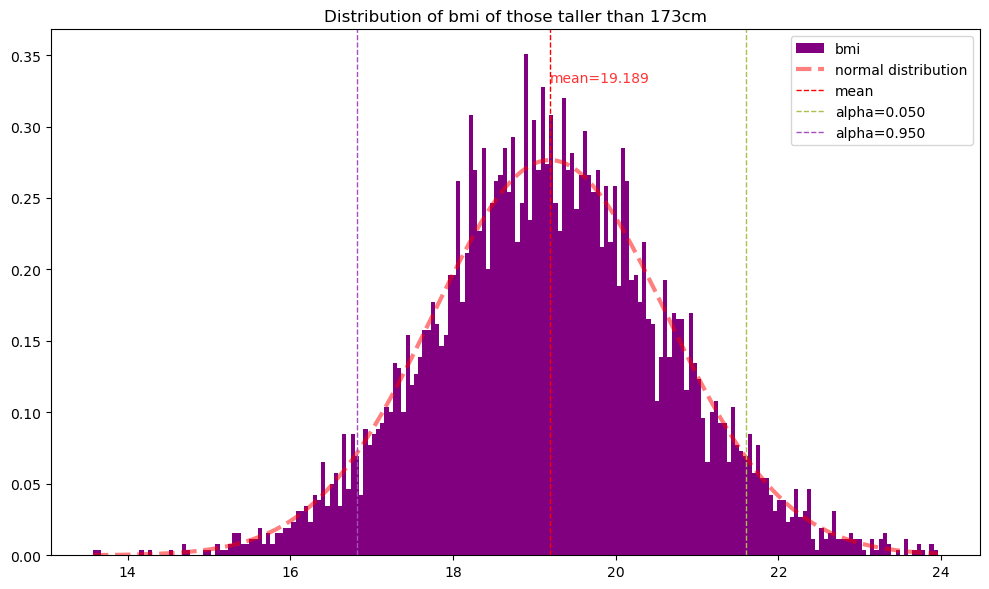

In [131]:
# plot the bmi distribution of the two groups
plot_histogram(bmi_taller,
               title='Distribution of bmi of those taller than 173cm',
               label='bmi',
               bins=200,
               color='purple', mark_alpha=[0.05, 0.95], plot_normal_distribution=True,
               density=True,
               filename="../image/高个子bmi.svg",
               save=save_flag)

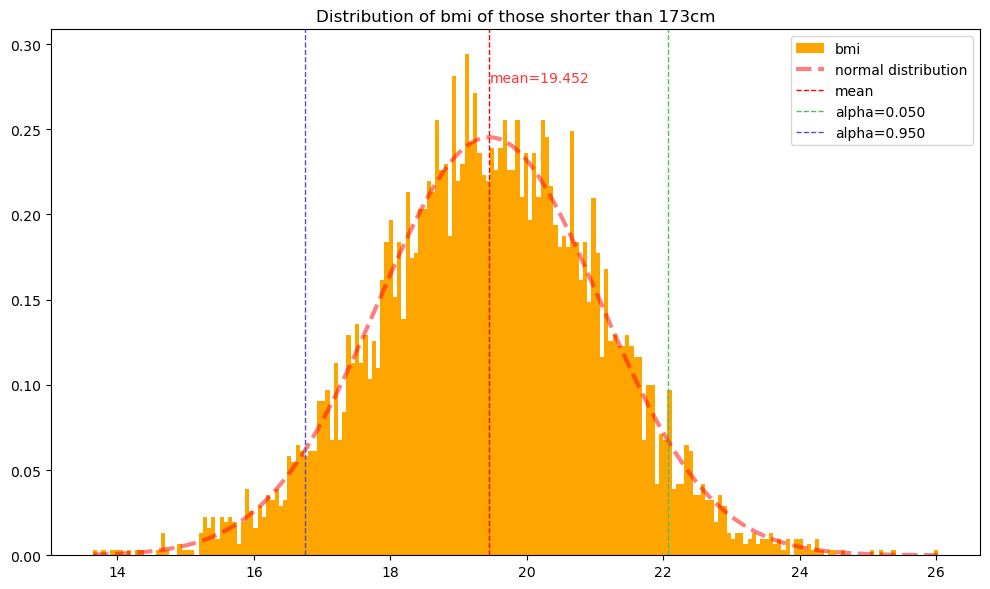

In [132]:
plot_histogram(bmi_shorter,
               title='Distribution of bmi of those shorter than 173cm',
               label='bmi',
               bins=200,
               color='orange',
               mark_alpha=[0.05, 0.95], plot_normal_distribution=True,
               density=True,
               filename="../image/矮个子bmi.svg",
               save=save_flag)

可以看出，两个分布接近正态分布，且均值不同。
接下来，我们将进行假设检验。

In [117]:
assert bmi_taller.shape[0] == bmi_shorter.shape[0]
bmi_diff = bmi_taller - bmi_shorter
bmi_diff.shape


(5000,)

In [118]:
res3 = stats.ttest_1samp(bmi_diff, 0, alternative='two-sided')

In [119]:
res3

TtestResult(statistic=-8.622346058507647, pvalue=8.68823888509016e-18, df=4999)

In [120]:
print(res3.pvalue)

8.68823888509016e-18


In [121]:
stats.ttest_1samp(bmi_diff[:500], 0, alternative='two-sided')

TtestResult(statistic=-2.631121047766084, pvalue=0.008773617366256611, df=499)

p值为8.68823888509016e-18，近似为0。

这说明在0.95显著性水平下，我们可以拒绝原假设，即身高高于173cm的bmi显著不同于身高不高于173cm的bmi的均值。

事实上，即使降低样本数量到500，p值也小于0.05（0.00877），我们仍然可以拒绝原假设。